# Introduction
Armed with the basic prerequisite knowledge of deep learning, we shall tackle a problem using a multilayer perceptron (MLP).

The term, MLP, is used to distinguish itself, a feedforward artificial neural network, from other deep learning models we will learn about in the future.

This notebook is done using Tensorflow. A version done using PyTorch is available [here](https://colab.research.google.com/drive/1EV0lOoXiM9N_66edMLQSNuqHJRmVh6eF?usp=sharing).

# The Problem
Given the temperature, humidity, wind speed, and precipitation percentage, can we predict whether the weather type is rainy or sunny?

# Set Seed
To ensure this notebook is deterministic, we will set the random seed.

In [ ]:
import tensorflow as tf
import random
import numpy as np

tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# Get Data
Here, we will fetch and load the data into a tensor that we will use for training.

Data source: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification

In [ ]:
import urllib

import pandas as pd

data_url = "https://g-2aaf39.eeb47.a567.data.globus.org/weather_classification_data.csv"
data_buffer = urllib.request.urlopen(data_url)

df = pd.read_csv(data_buffer)

In [ ]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Let's retain only the columns we need.

In [ ]:
X_df = df[['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)']]
Y_df = df['Weather Type']

Then, only keep the rows where the weather type is rainy or sunny.

In [ ]:
X_df = X_df.loc[(df['Weather Type']=='Rainy') | (df['Weather Type']=='Sunny')]
Y_df = Y_df.loc[(df['Weather Type']=='Rainy') | (df['Weather Type']=='Sunny')]

Transform $Y$ labels to binary labels.

In [ ]:
Y_df[Y_df == 'Rainy'] = 0
Y_df[Y_df == 'Sunny'] = 1

Y_df = Y_df.astype(int)

In [ ]:
X_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%)
0,14.0,73,9.5,82.0
2,30.0,64,7.0,16.0
3,38.0,83,1.5,82.0
4,27.0,74,17.0,66.0
9,28.0,74,8.5,107.0


In [ ]:
Y_df.head()

,Weather Type
0,0
2,1
3,1
4,0
9,1


Recall that $X$ has shape $n_x\times m$, and $Y$ has shape $n_y\times m$. However, one should always check the convention of the library that they use. In the case of Tensorflow, a linear layer expects an input of $m\times n_\text{in}$ and has an output of $m\times n_\text{out}$.

Thus, columns are features and rows are each observation, and we can convert the dataframes into tensors directly.

In [ ]:
X = X_df.values
Y = Y_df.values.reshape(-1, 1)

In [ ]:
X

array([[14. , 73. ,  9.5, 82. ],
       [30. , 64. ,  7. , 16. ],
       [38. , 83. ,  1.5, 82. ],
       ...,
       [31. , 24. ,  8. ,  5. ],
       [10. , 74. , 14.5, 71. ],
       [-5. , 38. ,  0. , 92. ]])

In [ ]:
X.shape

(6600, 4)

In [ ]:
Y

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [ ]:
Y.shape

(6600, 1)

# Normalize and Split Data
We shall normalize our data using minmax scaling. Recall, it is given by: $$x'=\frac{x-x_{\text{min}}}{x_{\text{max}}-x_{\text{min}}}$$

Note that when finding the min and max for $X$, we must define that we are taking this metric along the first axis. Thus, a $1\times3$ mean will be produced from a $13200\times3$ $X$.

In [ ]:
X_max = tf.reduce_max(X, axis=0)
X_min = tf.reduce_min(X, axis=0)
Y_max = tf.reduce_max(Y)
Y_min = tf.reduce_min(Y)

Xp = (X - X_min) / (X_max - X_min)
Yp = (Y - Y_min) / (Y_max - Y_min)

Now, let's split our data.

In [ ]:
m = len(X)
split_n = [int(n) for n in [m*p for p in [0.8*0.8, 0.8*0.2, 0.2]]]

X_train, X_val, X_test = tf.split(Xp, split_n)
Y_train, Y_val, Y_test = tf.split(Yp, split_n)

# Create Model Class
Let's start with a basic model, with one hidden layer of 3 neurons.

In Tensorflow, the input dimensions are inferred but can be explicitly defined.

Take note of the structure of the model class. We inherit from `tensorflow.keras.Model`, define layers in `__init__()`, and implement `call()` using our previously defined layers.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Normalization

class MyModel(Model):
    def __init__(self):
        super().__init__()

        self.stack = tf.keras.Sequential([
            tf.keras.Input(shape=(4,)),
            Dense(3, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

    def call(self, x):
        x = self.stack(x)
        return x

# Train and Test
References:
1. https://www.tensorflow.org/tutorials/quickstart/advanced
2. https://www.tensorflow.org/guide/effective_tf2


Let's train for 100 epochs.

In [ ]:
EPOCHS = 100

model1 = MyModel()

model1.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

## Using Keras Training Loop
If you don't need low-level control of your training process, using Keras' built-in fit, evaluate, and predict methods is recommended.


Initialize model, loss, and optimizer, then fit.

In [ ]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

model1.compile(optimizer=optimizer, loss=loss_fn, metrics=[
    tf.keras.metrics.BinaryAccuracy()
])

history = model1.fit(X_train, Y_train, epochs=EPOCHS, verbose=2,
                     validation_data=(X_val, Y_val))

Epoch 1/100
132/132 - 5s - 42ms/step - binary_accuracy: 0.6768 - loss: 0.2212 - val_binary_accuracy: 0.7831 - val_loss: 0.2094
Epoch 2/100
132/132 - 1s - 6ms/step - binary_accuracy: 0.8438 - loss: 0.2046 - val_binary_accuracy: 0.8741 - val_loss: 0.1951
Epoch 3/100
132/132 - 2s - 13ms/step - binary_accuracy: 0.8823 - loss: 0.1904 - val_binary_accuracy: 0.8845 - val_loss: 0.1818
Epoch 4/100
132/132 - 1s - 9ms/step - binary_accuracy: 0.8852 - loss: 0.1771 - val_binary_accuracy: 0.8835 - val_loss: 0.1698
Epoch 5/100
132/132 - 1s - 8ms/step - binary_accuracy: 0.8854 - loss: 0.1652 - val_binary_accuracy: 0.8816 - val_loss: 0.1593
Epoch 6/100
132/132 - 1s - 8ms/step - binary_accuracy: 0.8873 - loss: 0.1548 - val_binary_accuracy: 0.8816 - val_loss: 0.1503
Epoch 7/100
132/132 - 1s - 8ms/step - binary_accuracy: 0.8873 - loss: 0.1458 - val_binary_accuracy: 0.8826 - val_loss: 0.1426
Epoch 8/100
132/132 - 1s - 7ms/step - binary_accuracy: 0.8875 - loss: 0.1382 - val_binary_accuracy: 0.8816 - val_los

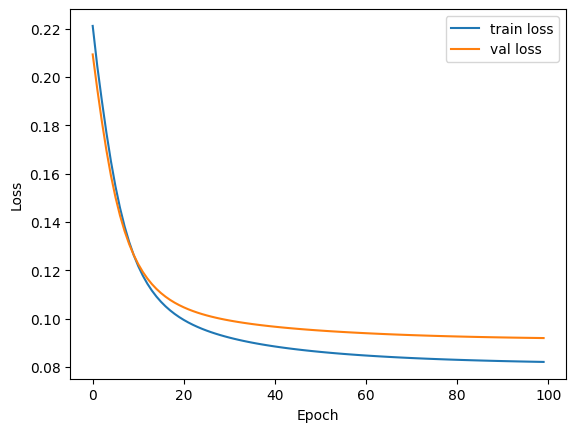

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

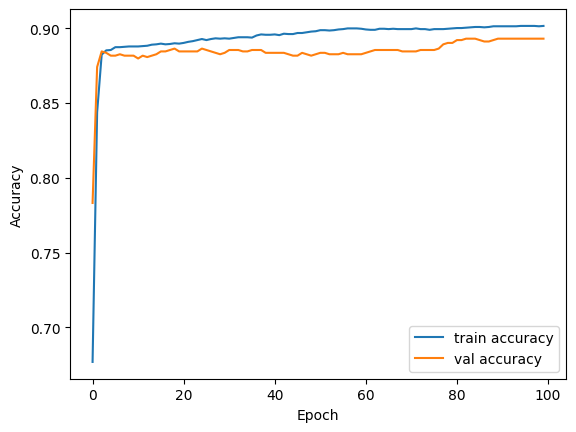

In [ ]:
plt.plot(history.history['binary_accuracy'], label='train accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val accuracy')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import numpy as np

model1.evaluate(X_test, Y_test, verbose=2);

42/42 - 0s - 4ms/step - binary_accuracy: 0.8962 - loss: 0.0873


## Using Custom Training Loop

`tf.function` is a function wrapper that compiles a function into a callable Tensorflow graph. Note that functions decorated by `tf.function` only take two variables: the inputs and the target labels. Thus, `model`, `loss_fn`, etc. must all be defined before the functions and cannot be passed in.

Note that decorating with `tf.function` isn't actually necessary, it just generally improves performance. Try running this notebook without the decorators. The model still trains.

Furthermore, it is good practice to ensure functions work as intended before wrapping them with `tf.function`.

https://www.tensorflow.org/guide/function

In [ ]:
model2 = MyModel()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

@tf.function
def train_step(X, Y):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model2(X, training=True)
        loss = loss_fn(Y, predictions)
    gradients = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))

    train_loss(loss)
    train_accuracy(Y, predictions)

@tf.function
def val_step(X, Y):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model2(X, training=False)
    v_loss = loss_fn(Y, predictions)

    val_loss(v_loss)
    val_accuracy(Y, predictions)

@tf.function
def test_step(X, Y):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model2(X, training=False)
    t_loss = loss_fn(Y, predictions)

    test_loss(t_loss)
    test_accuracy(Y, predictions)

More epochs are required by manual training loop to achieve similar results to that of default training loop.

In [ ]:
EPOCHS = 1000

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    train_step(X_train, Y_train)

    val_step(X_val, Y_val)

    if epoch % (EPOCHS/10) == 0:
        print(
            f'Epoch {epoch}, '
            f'Loss: {train_loss.result():0.2f}, '
            f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
            f'Val Loss: {val_loss.result():0.2f}, '
            f'Val Accuracy: {val_accuracy.result() * 100:0.2f}'
        )

    train_losses.append(train_loss.result())
    train_accuracies.append(train_accuracy.result())
    val_losses.append(val_loss.result())
    val_accuracies.append(val_accuracy.result())

Epoch 0, Loss: 0.24, Accuracy: 48.89, Val Loss: 0.24, Val Accuracy: 51.99
Epoch 100, Loss: 0.23, Accuracy: 58.12, Val Loss: 0.23, Val Accuracy: 60.51
Epoch 200, Loss: 0.21, Accuracy: 73.75, Val Loss: 0.21, Val Accuracy: 73.11
Epoch 300, Loss: 0.20, Accuracy: 81.87, Val Loss: 0.20, Val Accuracy: 80.68
Epoch 400, Loss: 0.18, Accuracy: 86.15, Val Loss: 0.18, Val Accuracy: 84.66
Epoch 500, Loss: 0.17, Accuracy: 88.23, Val Loss: 0.17, Val Accuracy: 86.74
Epoch 600, Loss: 0.16, Accuracy: 89.46, Val Loss: 0.16, Val Accuracy: 88.45
Epoch 700, Loss: 0.15, Accuracy: 90.25, Val Loss: 0.15, Val Accuracy: 88.26
Epoch 800, Loss: 0.14, Accuracy: 90.51, Val Loss: 0.14, Val Accuracy: 88.54
Epoch 900, Loss: 0.13, Accuracy: 90.89, Val Loss: 0.13, Val Accuracy: 89.02
Epoch 1000, Loss: 0.12, Accuracy: 91.22, Val Loss: 0.12, Val Accuracy: 89.30


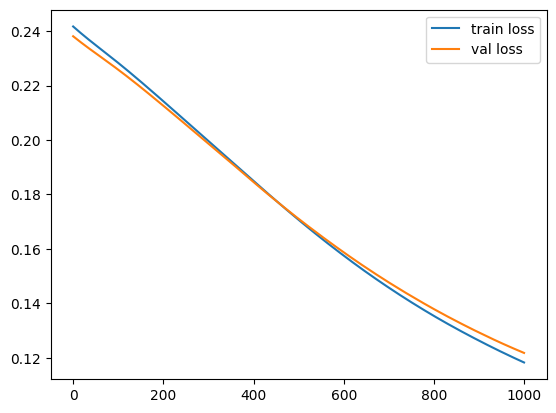

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

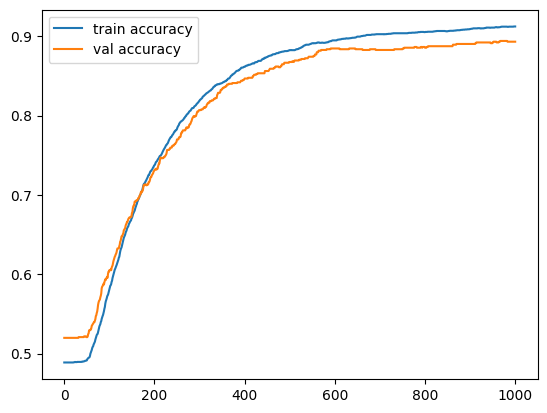

In [ ]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(val_accuracies, label='val accuracy')
plt.legend()
plt.show()

In [ ]:
test_step(X_test, Y_test)

print(
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
)

Test Loss: 0.12, Test Accuracy: 89.77
